# OpenVINO Inference with Salt Detection Model

In this tutorial, we will use the [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download)  to perform inference on the [salt model](https://github.com/waldeland/CNN-for-ASI), based on [Convolutional neural networks for automated seismic interpretation](https://library.seg.org/doi/abs/10.1190/tle37070529.1).

This tutorial assumes that you have already downloaded and installed the [Intel® Distribution of OpenVINO™ Toolkit](https://software.intel.com/en-us/openvino-toolkit/choose-download). This tutorial also assumes that you have initialized the OpenVINO environment. If you have not done so, please enter:
```
$ source /opt/intel/openvino/bin/setupvars.sh
```


In order to use Intel® Distribution of OpenVINO™, we need to do a few steps:
1. Convert our Pytorch model to an Onnx representation.
1. Use the [OpenVINO Model Optimizer](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) to convert ONNX model to OpenVINO Intermediate Representation (IR) format
1. Test the model with sample inference using the [OpenVINO Inference Engine](https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_Deep_Learning_Inference_Engine_DevGuide.html)


### Import neccessary packages

In [ ]:
#%pip install segyio ipyvolume pyvista pvgeo

In [1]:
import os
import shutil
import subprocess
import sys
#import segyio

import mo_onnx
import numpy as np
import torch
from openvino.inference_engine import IECore
from texture_net import TextureNet
from tqdm import tqdm

## Convert Pytorch Model to Onnx Representation
Run the cells below to convert the original Pytorch model into a onnx representation. We need to do this in order to convert to OpenVINO IR.

In [2]:
pytorch_model = "model/saved_model.pt"

device = torch.device("cpu")
network = TextureNet(n_classes=2)
network.load_state_dict(torch.load(pytorch_model, map_location=device))
network.eval()

input_var = torch.randn(1, 1, 65, 65, 65)

# Save the model to path specified.
model_fname = "./textureNet/textureNet.onnx"
out_dir = os.path.dirname(model_fname)

# if os.path.isdir(out_dir):
#     print(f"{out_dir} exists already. Deleting the folder")
#     shutil.rmtree(out_dir)
# os.mkdir(out_dir)

# print("\nExporting PyTorch model to ONNX format ...")
# torch.onnx.export(network, input_var, model_fname, export_params=True)
# print(f"Model saved at {model_fname}")

## Convert Onnx Representation to OpenVINO IR
Run the cells below to convert the Onnx model to its OpenVINO IR equivalent.


In [3]:
# Setup model optimizer command ...
ir_name = "textureNet"
ir_data_type = "FP32"
ir_out_dir = f"{out_dir}/IR_models/{ir_data_type}"

mo_script = mo_onnx.__file__
mo_cmd = f""""{sys.executable}" "{mo_script}" \
      --input_model "{model_fname}" \
      --keep_shape_ops \
      --data_type {ir_data_type} \
      --output_dir "{ir_out_dir}"  \
      --model_name "{ir_name}"
      """

In [4]:
print("Running model optimizer to convert model to OpenVINO IR format ....")
print("\n--".join(mo_cmd.split("--")))

# output = subprocess.check_output(mo_cmd, shell=True)
# print(output.decode("utf-8"))

Running model optimizer to convert model to OpenVINO IR format ....
"C:\Users\havanden\openvino_env\Scripts\python.exe" "C:\Users\havanden\openvino_env\lib\site-packages\mo_onnx.py"       
--input_model "./textureNet/textureNet.onnx"       
--keep_shape_ops       
--data_type FP32       
--output_dir "./textureNet/IR_models/FP32"        
--model_name "textureNet"
      


#### Now we will test our model with the generated validation set and then a F3 dataset block.

### Downloading F3 Dataset
If you would like to experiment on more data, you download the [dataset](https://drive.google.com/drive/folders/0B7brcf-eGK8CbGhBdmZoUnhiTWs) used in FaultSeg. We have chosen sample data from the F3 dataset. Install gdown for easy Google Drive downloading.

## Sample Inference on F3 sample Data block with OpenVINO Inference Engine

### Load and pre-process the F3 Data Block

#### Import neccessary packages

In [5]:
filename = "./data/f3-sample.npy"
dataset_name = "F3"
subsampl = 16
im_size = 65

data = np.load(filename)
# data = segyio.tools.cube(r"data/Dutch Government_F3_entire_8bit seismic.segy")
data = np.moveaxis(data, -1, 0)
data = np.ascontiguousarray(data, "float32")

data_info = {}
data_info["shape"] = data.shape

**Note:** Here we are using a sample from F3 data block which is saved in `.npy` format. We can load any `SEGY` format data using a python library [SEGYIO](https://github.com/equinor/segyio). A code snippet for loading of `segy` data :
```
import segyio
data = segyio.tools.cube(filename)
```

Now, lets continue with our example...


In [6]:
def ls(N):
    return np.linspace(0, N - 1, N, dtype="int")


N0, N1, N2 = data.shape
x0_range = ls(N0)
x1_range = ls(N1)
x2_range = ls(N2)
pred_points = (x0_range[::subsampl], x1_range[::subsampl], x2_range[::subsampl])
class_cube = data[::subsampl, ::subsampl, ::subsampl] * 0

In [7]:
print(f"Loaded Data info: \n{data_info}")
print(f"Class cube shape: {class_cube.shape}")

Loaded Data info: 
{'shape': (100, 250, 250)}
Class cube shape: (7, 16, 16)


In [8]:
n0, n1, n2 = class_cube.shape
x0_grid, x1_grid, x2_grid = np.meshgrid(
    ls(
        n0,
    ),
    ls(n1),
    ls(n2),
    indexing="ij",
)
X0_grid, X1_grid, X2_grid = np.meshgrid(
    x0_range, x1_range, x2_range, indexing="ij"
)

X0_grid_sub = X0_grid[::subsampl, ::subsampl, ::subsampl]
X1_grid_sub = X1_grid[::subsampl, ::subsampl, ::subsampl]
X2_grid_sub = X2_grid[::subsampl, ::subsampl, ::subsampl]

w = im_size // 2

### Load the OpenVINO IR network 

In [9]:
model_xml = f"{ir_out_dir}/{ir_name}.xml"
model_bin = f"{ir_out_dir}/{ir_name}.bin"

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)
exec_net = ie.load_network(network=net, device_name="CPU")
del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

### Run the inference

<b>Warning:</b> Depending on your machine, this may take some time.

In [10]:

for i in tqdm(range(X0_grid_sub.size)):
    x0, x1, x2 = x0_grid.ravel()[i], x1_grid.ravel()[i], x2_grid.ravel()[i]
    X0, X1, X2 = X0_grid_sub.ravel()[i], X1_grid_sub.ravel()[i], X2_grid_sub.ravel()[i]
    if X0>w and X1>w and X2>w and X0<N0-w+1 and X1<N1-w+1 and X2<N2-w+1:
        mini_cube = data[X0-w:X0+w+ 1, X1-w:X1+w+ 1, X2-w:X2+w+ 1]
        out = exec_net.infer({input_layer: mini_cube})[output_layer]

        out = out[:,:, out.shape[2]//2, out.shape[3]//2, out.shape[4]//2]
        out = np.squeeze(out)

        # Make one output pr output channel
        if type(class_cube) != type(list()):
            class_cube = np.split( np.repeat(class_cube[:,:,:,np.newaxis],out.size,3),out.size, axis=3)

        # Insert into output
        if out.size == 1:
            class_cube[0][x0, x1, x2] = out
        else:
            for i in range(out.size):
                class_cube[i][x0,x1,x2] = out[i]

100%|████████████████████████| 1792/1792 [00:00<00:00, 2178.41it/s]


### Interpolate the results back to the class_cube
<b>Warning:</b> Depending on your machine, this may take some time.

In [11]:

#Interpolation
from scipy.interpolate import interpn
N = X0_grid.size
grid_output_cube = np.concatenate( [X0_grid.reshape([N, 1]), X1_grid.reshape([N, 1]), X2_grid.reshape([N, 1])], 1)

for i in tqdm(range(len(class_cube))):
    is_int = np.sum(np.unique(class_cube[i]).astype('float') - np.unique(class_cube[i]).astype('int32').astype('float') ) == 0
    class_cube[i] = interpn(pred_points, class_cube[i].astype('float').squeeze(), grid_output_cube, method='linear', fill_value=0, bounds_error=False)
    class_cube[i] = class_cube[i].reshape([x0_range.size, x1_range.size, x2_range.size])

    if is_int:
        class_cube[i] = class_cube[i].astype('int32')

100%|████████████████████████████████| 2/2 [00:05<00:00,  2.98s/it]


In [12]:
# Squeeze outputs
for i in range(len(class_cube)):
    class_cube[i] = class_cube[i].squeeze()

### Plot Inference results
As the inference is done on the whole cube, we can select few slices to view the results

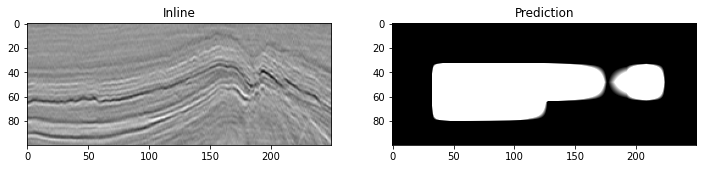

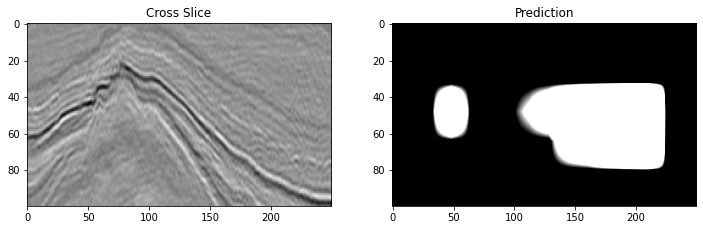

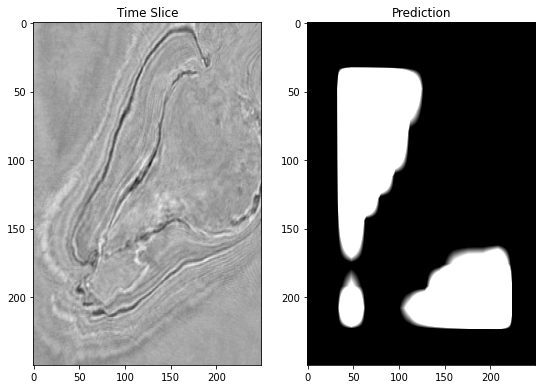

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from PIL import Image

k1,k2,k3 = 40,200,50

gx1 = data[k1, :, :]
gy1 = class_cube[0][k1, :, :]
gx2 = data[:, k2, :]
gy2 = class_cube[0][:, k2, :]
gx3 = data[:, :, k3]
gy3 = class_cube[0][:, :, k3]

# Inline slice
fig = plt.figure(figsize=(12, 12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3, cmap=plt.cm.gray)
plt.title("Inline")
p2 = plt.subplot(1, 2, 2)
p2.imshow(gy3, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.title("Prediction")

# Crossline slice
fig = plt.figure(figsize=(12, 12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2, aspect=1.5, cmap=plt.cm.gray)
plt.title("Cross Slice")
p2 = plt.subplot(1, 2, 2)
p2.imshow(
    gy2,
    aspect=1.5,
    interpolation="bilinear",
    vmin=0.4,
    vmax=1.0,
    cmap=plt.cm.gray,
)
plt.title("Prediction")

# Time slice
fig = plt.figure(figsize=(9, 9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1, aspect=1.5, cmap=plt.cm.gray)
plt.title("Time Slice")
p2 = plt.subplot(1, 2, 2)
p2.imshow(
    gy1,
    aspect=1.5,
    interpolation="bilinear",
    vmin=0.4,
    vmax=1.0,
    cmap=plt.cm.gray,
)
plt.title("Prediction")
plt.show()

In [14]:
# import PVGeo

# from PVGeo.filters import VoxelizePoints
# %matplotlib widget
# pv.set_plot_theme('document')

# # points = np.argwhere(class_cube[0] > 0.5)
# points = np.argwhere(cube > 0.5)

# print('Voxelizing...')

# vtkpoints = PVGeo.points_to_poly_data(points)
# voxelizer = PVGeo.filters.VoxelizePoints()
# salt_voxels = voxelizer.apply(vtkpoints)
# salt_voxels['elevation'] = points[:,:]

# print('Done...')

In [15]:
# salt = salt_voxels.extract_geometry() 

In [16]:
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(600, 400))
# display.start()

In [17]:
import pyvista as pv

grid = pv.UniformGrid()
grid_values = data[:,:,:]
grid.dimensions = np.array(grid_values.shape)+ 1
grid.cell_arrays["values"] = grid_values.flatten(order="F")

In [21]:
!pip install traitlets==4.*

  Using cached traitlets-4.3.3-py2.py3-none-any.whl (75 kB)
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.0.5
    Uninstalling traitlets-5.0.5:
      Successfully uninstalled traitlets-5.0.5


In [22]:
%matplotlib widget
import ipyvolume as ipv
ipv.figure()
m = ipv.plot_mesh(grid_values[0], grid_values[1], grid_values[2], wireframe=False)
ipv.squarelim()
ipv.show()

In [ ]:
# plotter = pv.Plotter()
# outline = grid.outline()
# plotter.add_mesh(grid, name='volume',show_edges=False, cmap="Greys", opacity=0.25)
# plotter.add_mesh(salt, show_edges=False, color="487DBE", show_scalar_bar=False)
# plotter.add_mesh(outline, color='black')
# plotter.add_axes()
# plotter.show()